<a href="https://colab.research.google.com/github/Anudeep28/Speech_to_Text/blob/main/speech_2_text_whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Python Code version 1 from link: https://thepythoncode.com/article/speech-recognition-using-huggingface-transformers-in-python
* Steps:
1. Automatic Speech Recognition (ASR) is the technology that allows us to convert human speech into digital text. This tutorial will dive into using the Huggingface Transformers library in Python to perform speech recognition using two of the most-known and state-of-the-art models, which are Wav2Vec 2.0 and Whisper.
2. **`Wav2Vec2`** is a pre-trained model that was trained on speech audio alone (self-supervised) and then followed by fine-tuning on transcribed speech data (LibriSpeech dataset). It has outperformed previous semi-supervised models.
3. **`Whisper`**, on the other hand, is a general-purpose speech recognition transformer model, trained on a large dataset of diverse weakly supervised audio (680,000 hours) on multiple languages and also multiple tasks (speech recognition, speech translation, language identification, and voice activity detection).

Tutorial:
- Getting Started
- Using Wav2Vec 2.0 Models
  - Loading the Model
  - Preparing the Audio File
  - Performing Inference
  - Wrapping up the Code
- Using Whisper Models
  - Loading the Model
  - Preparing the Audio File
  - Performing Inference
  - Wrapping up the Code
- Transcribing your Voice
- Transcribing Long Audio Samples
- Conclusion

We'll be using torchaudio for loading audio files. Note that you need to install PyAudio if you're going to use the code on your environment and PyDub if you're on a Colab environment. We are going to use them for recording from the microphone in Python.

In [1]:
!pip install transformers==4.28.1 soundfile sentencepiece torchaudio pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

Using Whisper Models
The cool thing about Whisper is that there is a single model for almost all the world languages, and you only have to specify the language by prepending the decoding with special language tokens.

The below tables show the different Whisper models, their number of parameters, size, and links to multilingual and English-only models:

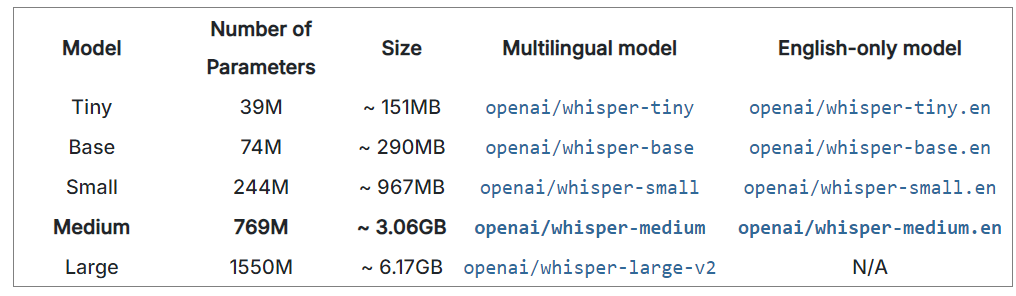

Loading the Model
Let's load the openai/whisper-medium one:

In [5]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, WhisperProcessor, WhisperForConditionalGeneration
import torch
import soundfile as sf
import librosa
import os
import torchaudio

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
# whisper_model_name = "openai/whisper-tiny.en" # English-only, ~ 151 MB
# whisper_model_name = "openai/whisper-base.en" # English-only, ~ 290 MB
# whisper_model_name = "openai/whisper-small.en" # English-only, ~ 967 MB
# whisper_model_name = "openai/whisper-medium.en" # English-only, ~ 3.06 GB
# whisper_model_name = "openai/whisper-tiny" # multilingual, ~ 151 MB
# whisper_model_name = "openai/whisper-base" # multilingual, ~ 290 MB
# whisper_model_name = "openai/whisper-small" # multilingual, ~ 967 MB
whisper_model_name = "openai/whisper-medium" # multilingual, ~ 3.06 GB
# whisper_model_name = "openai/whisper-large-v2" # multilingual, ~ 6.17 GB
# load the whisper model and tokenizer
whisper_processor = WhisperProcessor.from_pretrained(whisper_model_name)
whisper_model = WhisperForConditionalGeneration.from_pretrained(whisper_model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

We use the WhisperProcessor to process our audio file, and WhisperForConditionalGeneration for loading the model.

If get an out-of-memory error, you're free to use a smaller Whisper model, such as openai/whisper-tiny.

Preparing the Audio File
Let's use the same audio_url defined earlier. First, extracting the audio features:

In [4]:
# Gettign the audio file
# audio_url = "https://github.com/x4nth055/pythoncode-tutorials/raw/master/machine-learning/speech-recognition/16-122828-0002.wav"
audio_url = "https://github.com/x4nth055/pythoncode-tutorials/raw/master/machine-learning/speech-recognition/30-4447-0004.wav"
# audio_url = "https://github.com/x4nth055/pythoncode-tutorials/raw/master/machine-learning/speech-recognition/7601-291468-0006.wav"

In [6]:
def load_audio(audio_path):
  """Load the audio file & convert to 16,000 sampling rate"""
  # load our wav file
  speech, sr = torchaudio.load(audio_path)
  resampler = torchaudio.transforms.Resample(sr, 16000)
  speech = resampler(speech)
  return speech.squeeze()

In [7]:
# get the input features
input_features = whisper_processor(load_audio("t1.mp3"), sampling_rate=16000, return_tensors="pt").input_features.to(device)
input_features.shape

torch.Size([1, 80, 3000])

Very Good website t understand more in details: https://github.com/openai/whisper

We set the language to "english" and the task to "transcribe" for English speech recognition. Here's the output:

In [11]:
# get special decoder tokens for the language
forced_decoder_ids = whisper_processor.get_decoder_prompt_ids(language="english", task="transcribe")
forced_decoder_ids

[(1, 50259), (2, 50359), (3, 50363)]

In [12]:
# perform inference
predicted_ids = whisper_model.generate(input_features, forced_decoder_ids=forced_decoder_ids)
predicted_ids.shape

torch.Size([1, 39])

In [13]:
# decode the IDs to text
transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)
transcription

[' Perhaps he made up to the party afterwards, and took her, and his heart at hand continued. It was not fear-eyes set it over her. Edmund']

Wrapping up the Code
Let's now wrap everything into a single function, as previously:

In [20]:
# %%writefile going_modular/whisper_result.py
# import torchaudio
# import torch

def load_audio(audio_path):
  """Load the audio file & convert to 16,000 sampling rate"""
  # load our wav file
  speech, sr = torchaudio.load(audio_path)
  resampler = torchaudio.transforms.Resample(sr, 16000)
  speech = resampler(speech)
  return speech.squeeze()

def get_transcription_whisper(audio_path, model, processor, language="english", skip_special_tokens=True):
  # resample from whatever the audio sampling rate to 16000
  speech = load_audio(audio_path)
  # get the input features
  input_features = processor(speech, return_tensors="pt", sampling_rate=16000).input_features.to(device)
  # get special decoder tokens for the language
  forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task="transcribe")
  # perform inference
  predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)
  # decode the IDs to text
  transcription = processor.batch_decode(predicted_ids, skip_special_tokens=skip_special_tokens)[0]
  return transcription

In [26]:
get_transcription_whisper("t2_m.m4a", whisper_model, whisper_processor,
                          language="marathi")

' मुंबई ही भारताची आर्थिक वमनोरणजनाची राज़धानिया है। रिसर्वो बंक, मुंबई शेर बाजार, राश्ट्रिय शेर बाजार या महत्वाचा आर्थिक सांस्थाया शहराता है।'

In [27]:
get_transcription_whisper("t1.mp3", whisper_model, whisper_processor,
                          language="english")

' Perhaps he made up to the party afterwards, and took her, and his heart at hand continued. It was not fear-eyes set it over her. Edmund'

Lets make the code more granular, to give an understandign of the language spoken, identitfy the language spoken
Link to them are here :
1. https://github.com/openai/whisper/discussions/categories/show-and-tell
2. https://github.com/davabase/whisper_real_time
3. https://github.com/davabase/transcriber_app/
4. https://skeptric.com/python-offline-translation/

List of languages available for whisper : https://github.com/openai/whisper/blob/main/whisper/tokenizer.py